# Mouse colonic mesenchyme
paper: https://doi.org/10.1016/j.stem.2021.10.004 
dataset from: https://doi.org/10.1038/s41586-020-2166-3


In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Get the original magma colormap
magma = plt.cm.get_cmap('magma', 256)

# Convert to array and prepend grey
magma_colors = magma(np.linspace(0, 1, 256))
grey = np.array([[0.8, 0.8, 0.8, 1.0]])  # RGBA for light grey

# Combine: grey for near-zero, then rest of magma
new_colors = np.vstack((grey, magma_colors[20:]))  # skip darkest part of magma
custom_cmap1 = ListedColormap(new_colors)

In [2]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt" 
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

In [3]:
adata1 = sc.read_csv("GSM4227211_C1A_gene_exon_tagged_dge.txt", delimiter='\t').T
adata2 = sc.read_csv("GSM4227212_C1B_gene_exon_tagged_dge.txt", delimiter='\t').T
adata3 = sc.read_csv("GSM4227213_C2A_gene_exon_tagged_dge.txt", delimiter='\t').T
adata4 = sc.read_csv("GSM4227214_C2B_gene_exon_tagged_dge.txt", delimiter='\t').T
adata5 = sc.read_csv("GSM4227215_C2C_gene_exon_tagged_dge.txt", delimiter='\t').T

In [4]:
def preprocess_adata(adata):
    # Mark mitochondrial and ribosomal genes
    adata.var['mt'] = adata.var_names.str.startswith("mt-")
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=['mt', 'ribo'],
        percent_top=None,
        log1p=False,
        inplace=True
    )

    # Filter cells and genes
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=5)

    # Mitochondrial filtering (MAD-based)
    mt = adata.obs['pct_counts_mt']
    mad = np.median(np.abs(mt - np.median(mt)))
    threshold = np.median(mt) + 2 * mad
    adata = adata[mt < threshold]

    # Normalize and log-transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Identify highly variable genes
    #sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2500)

    # Store raw data and subset to HVGs
    #adata.raw = adata.copy()
    #adata = adata[:, adata.var.highly_variable].copy()

    return adata

In [5]:
adata_combined = sc.concat([preprocess_adata(adata) for adata in [adata1, adata2, adata3, adata4, adata5]], 
                           label="batch", 
                           keys=["sample1", "sample2", "sample3", "sample4", "sample5"])

In [6]:
sc.pp.highly_variable_genes(adata_combined, flavor='seurat_v3', batch_key='batch', n_top_genes=2000)
adata_combined.raw = adata_combined.copy()
adata_combined = adata_combined[:, adata_combined.var.highly_variable].copy()

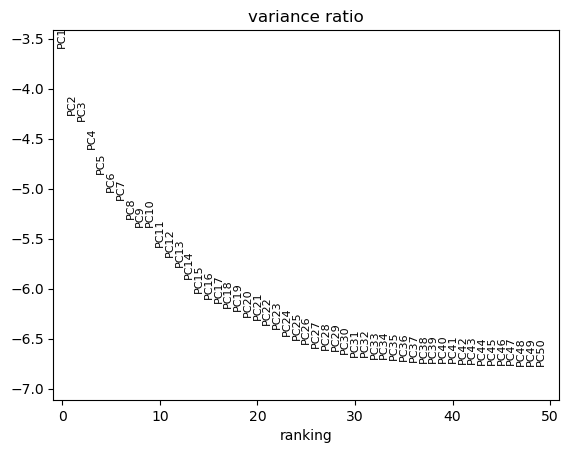

In [7]:
sc.pp.scale(adata_combined, max_value=10)
sc.tl.pca(adata_combined, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_combined, log=True, n_pcs = 50)

In [8]:
sc.external.pp.harmony_integrate(adata_combined, key='batch')
sc.pp.neighbors(adata_combined, n_neighbors = 20, n_pcs = 30, use_rep='X_pca_harmony')
sc.tl.umap(adata_combined)

2025-06-02 00:25:40,548 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
  File "C:\Users\dowpa\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\dowpa\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dowpa\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\dowpa\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
2025-06-02 00:25:41,521 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-02 00:25:41,569 - harmonypy - INFO - Iteration 1 of 10
2025-06-02 00:25:43,430 - harmonypy - INFO - Iteration 2 of 

In [9]:
sc.tl.leiden(adata_combined, resolution = 0.5)

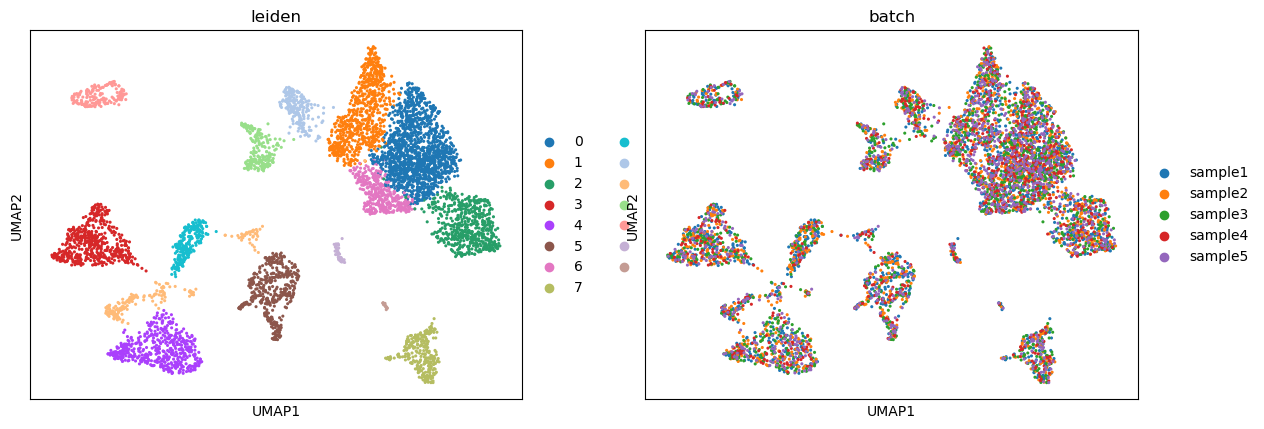

In [10]:
sc.pl.umap(adata_combined, color=['leiden', 'batch'], use_raw=True)

# GLIA


In [11]:
gbarcodes = adata_combined[adata_combined.obs['leiden'] == '7'].obs_names
print(gbarcodes)

Index(['AGACGGACTGCT', 'GTAACAATTCAT', 'AGGCTTAAACTT', 'GCAGAATTTGCG',
       'ACGCAGTCAATA', 'TTGGTTAACGAT', 'AAAATTTAGGCC', 'ATCTCCTCGGCC',
       'GTTTCCTTGGTC', 'CCCCATTGCATA',
       ...
       'TCCTCATGCCTA', 'CGTTGAACGCGG', 'ACTATTATTGAT', 'CCCCTTGACTTC',
       'GTTCCCGCGGCG', 'GATGTAGCGTGA', 'TAGTTAGAGTAG', 'TCACAGTGAATA',
       'CGAAACGTCCTA', 'GAGTGGGAGGAC'],
      dtype='object', length=288)


In [12]:
gadata1 = sc.read_csv("GSM4227211_C1A_gene_exon_tagged_dge.txt", delimiter='\t').T
gadata2 = sc.read_csv("GSM4227212_C1B_gene_exon_tagged_dge.txt", delimiter='\t').T
gadata3 = sc.read_csv("GSM4227213_C2A_gene_exon_tagged_dge.txt", delimiter='\t').T
gadata4 = sc.read_csv("GSM4227214_C2B_gene_exon_tagged_dge.txt", delimiter='\t').T
gadata5 = sc.read_csv("GSM4227215_C2C_gene_exon_tagged_dge.txt", delimiter='\t').T

In [13]:
def preprocess_gadata(gadata): 
    # Filter out non-glial cells
    gadata = gadata[gadata.obs_names.isin(gbarcodes)]
    
    # Mark mitochondrial and ribosomal genes
    gadata.var['mt'] = gadata.var_names.str.startswith("MT-")
    gadata.var['ribo'] = gadata.var_names.isin(ribo_genes[0].values)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(
        gadata,
        qc_vars=['mt', 'ribo'],
        percent_top=None,
        log1p=False,
        inplace=True
    )

    # Filter cells and genes
    sc.pp.filter_cells(gadata, min_genes=200)
    #sc.pp.filter_genes(gadata, min_cells=5)

    # Normalize and log-transform
    sc.pp.normalize_total(gadata, target_sum=1e4)
    sc.pp.log1p(gadata)

    # Identify highly variable genes
    #sc.pp.highly_variable_genes(gadata, flavor='seurat_v3', n_top_genes=2500)

    # Store raw data and subset to HVGs
    #gadata.raw = gadata.copy()
    #gadata = gadata[:, gadata.var.highly_variable].copy()

    return gadata

In [14]:
gadata_combined = sc.concat([preprocess_gadata(gadata) for gadata in [gadata1, gadata2, gadata3, gadata4, gadata5]], 
                           label="batch", 
                           keys=["sample1", "sample2", "sample3", "sample4", "sample5"])

In [15]:
sc.pp.filter_genes(gadata_combined, min_cells=3)

In [16]:
sc.pp.calculate_qc_metrics(
        gadata_combined,
        percent_top=None,
        log1p=False,
        inplace=True
    )

In [17]:
sc.pp.highly_variable_genes(gadata_combined, flavor='seurat_v3', batch_key='batch', n_top_genes=1500)
gadata_combined.raw = gadata_combined.copy()
gadata_combined = gadata_combined[:, gadata_combined.var.highly_variable].copy()

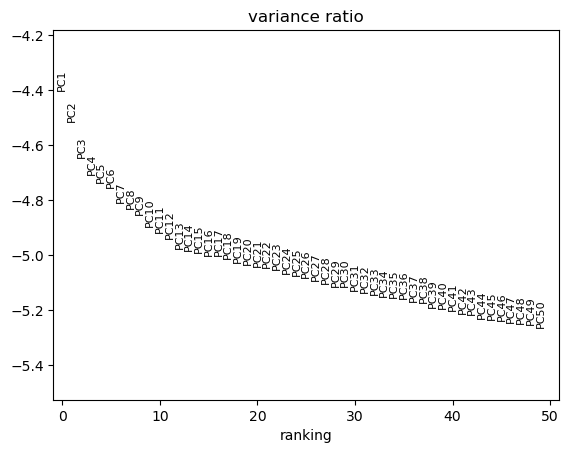

In [18]:
sc.pp.scale(gadata_combined, max_value=10)
sc.tl.pca(gadata_combined, svd_solver='arpack')
sc.pl.pca_variance_ratio(gadata_combined, log=True, n_pcs = 50)

In [19]:
sc.external.pp.harmony_integrate(gadata_combined, key='batch')
sc.pp.neighbors(gadata_combined, n_neighbors = 10, n_pcs = 15, use_rep='X_pca_harmony')
sc.tl.umap(gadata_combined)

2025-06-02 00:27:12,505 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-02 00:27:12,686 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-02 00:27:12,730 - harmonypy - INFO - Iteration 1 of 10
2025-06-02 00:27:12,797 - harmonypy - INFO - Iteration 2 of 10
2025-06-02 00:27:12,836 - harmonypy - INFO - Iteration 3 of 10
2025-06-02 00:27:12,859 - harmonypy - INFO - Iteration 4 of 10
2025-06-02 00:27:12,878 - harmonypy - INFO - Iteration 5 of 10
2025-06-02 00:27:12,894 - harmonypy - INFO - Iteration 6 of 10
2025-06-02 00:27:12,918 - harmonypy - INFO - Converged after 6 iterations


In [20]:
sc.tl.leiden(gadata_combined, resolution = 0.4)

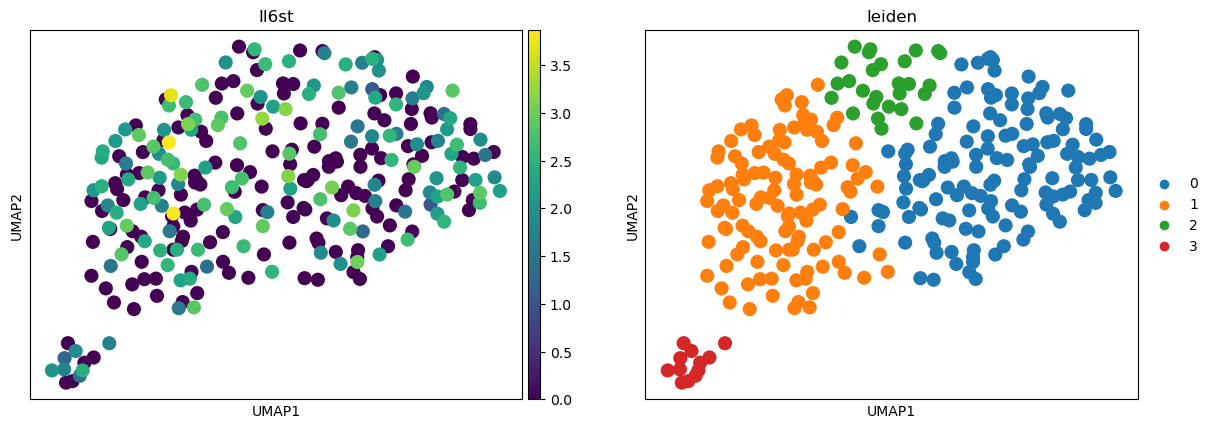

In [21]:
sc.pl.umap(gadata_combined, color=['Il6st', 'leiden'], use_raw=True)

In [22]:
mouse_cytokine_receptors = np.array([
    # Interleukin receptors
    "Il1r1", "Il1r2", "Il2ra", "Il2rb", "Il2rg", "Il3ra", "Il4ra", "Il5ra", "Il6ra", "Il6st",
    "Il7r", "Il9r", "Il10ra", "Il10rb", "Il11ra1", "Il12rb1", "Il12rb2", "Il13ra1", "Il13ra2",
    "Il15ra", "Il17ra", "Il17rb", "Il17rc", "Il17rd", "Il17re", "Il18r1", "Il18rap", "Il20ra",
    "Il20rb", "Il21r", "Il22ra1", "Il22ra2", "Il23r", "Il27ra", "Il28ra", "Il31ra",

    # Interferon receptors
    "Ifnar1", "Ifnar2", "Ifngr1", "Ifngr2", "Ifnlr1",

    # TNF receptor superfamily
    "Tnfrsf1a", "Tnfrsf1b", "Tnfrsf4", "Tnfrsf9", "Tnfrsf11a", "Tnfrsf13b", "Tnfrsf13c",
    "Tnfrsf14", "Tnfrsf17", "Tnfrsf18", "Tnfrsf25",

    # Chemokine receptors
    "Ccr1", "Ccr2", "Ccr3", "Ccr4", "Ccr5", "Ccr6", "Ccr7", "Ccr8", "Ccr9", "Ccr10",
    "Cxcr1", "Cxcr2", "Cxcr3", "Cxcr4", "Cxcr5", "Cxcr6", "Cx3cr1", "Xcr1",

    # CSF receptors
    "Csf1r", "Csf2ra", "Csf2rb", "Csf3r",

    # Other cytokine receptors
    "Crlf2", "Tslpr", "Osmr", "Lifr", "Cntfr", "Kit", "Flt3"
])

In [23]:
ctr_genes = np.intersect1d(mouse_cytokine_receptors, gadata_combined.raw.var.index)
ctr_genes

array(['Crlf2', 'Csf2ra', 'Csf2rb', 'Cxcr4', 'Ifnar1', 'Ifnar2', 'Ifngr1',
       'Ifngr2', 'Il10rb', 'Il11ra1', 'Il17ra', 'Il17rc', 'Il1r1',
       'Il1r2', 'Il20rb', 'Il3ra', 'Il4ra', 'Il6ra', 'Il6st', 'Il7r',
       'Lifr', 'Osmr', 'Tnfrsf1a', 'Tnfrsf1b'], dtype=object)

In [24]:
gadata_combined.raw.var[gadata_combined.raw.var.index.isin(ctr_genes)].sort_values('total_counts', ascending=False)

,n_cells,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Il6st,140,140,1.118915,51.557093,323.366302,False,651.0,1.118915,1.484837,1.015996,1
Ifnar2,80,80,0.602508,72.318339,174.124680,False,1227.0,0.602508,1.023529,1.025143,1
Tnfrsf1a,77,77,0.565350,73.356401,163.386154,False,1312.0,0.565350,0.939149,1.008311,1
Osmr,78,78,0.563926,73.010381,162.974564,False,NaN,0.563926,0.940264,0.991890,0
Il17ra,35,35,0.256572,87.889273,74.149208,True,322.0,0.256572,0.525685,1.122815,3
Ifngr1,21,21,0.140582,92.733564,40.628231,False,NaN,0.140582,0.269085,0.973410,0
Il10rb,19,19,0.124743,93.425606,36.050800,False,657.0,0.124743,0.231398,0.965434,1
Il4ra,13,13,0.085505,95.501730,24.710928,False,NaN,0.085505,0.161715,0.960197,0
Il17rc,13,13,0.082383,95.501730,23.808565,False,1180.0,0.082383,0.154570,1.030930,1
Csf2ra,12,12,0.078793,95.847751,22.771107,False,872.0,0.078793,0.157132,1.024215,2


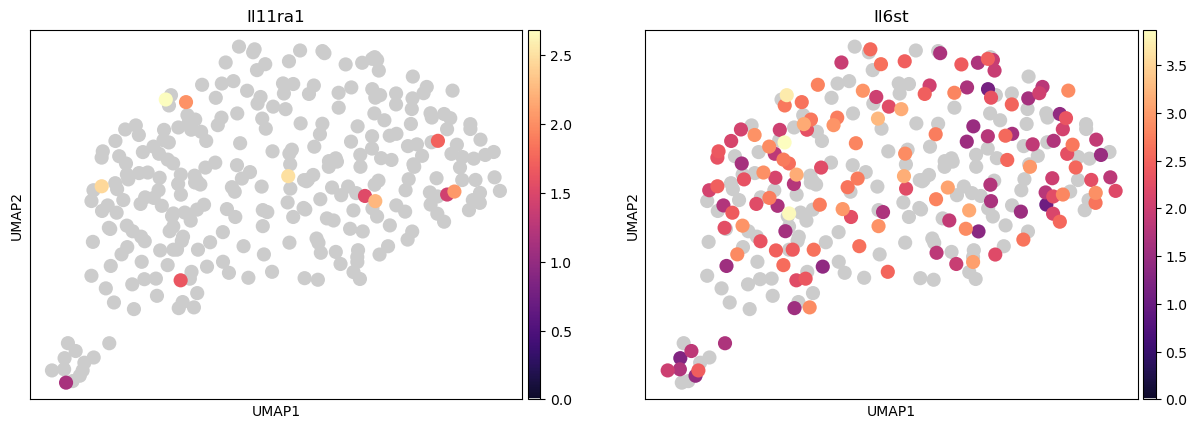

In [31]:
sc.pl.umap(gadata_combined, color=['Il11ra1', 'Il6st'], use_raw=True, cmap=custom_cmap1, save='glia_IL11.png')